# `DEPRESJON` - Exploring Gender Specific Machine Learning Models
## Model 2: Person level prediction using daily activity

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objectives**

* Recreate baseline models for Female/Male/All observations as done by (Garcia-Ceja et al., 2018)

**Files in Series**

* [wiki-08-base-1-eda](.\wiki-08-base-1-eda.ipynb)
* [wiki-08-base-2-person-days-rows](.\wiki-08-base-2-person-days-rows.ipynb)
* [wiki-08-base-3-person-prediction](.\wiki-08-base-3-person-prediction.ipynb)
* [wiki-08-base-4-person-hours.ipynb](.\wiki-08-base-4-person-hours.ipynb)



## Features

>"Each day was characterized by a feature vector which was computed by extracting a set of features **on a per day basis from the activity level**. The extracted features were the **mean activity level**, the corresponding **standard deviation** and the **percentage of events with no activity i.e, activity level = 0**. The features were **normalized between 0 and 1** before the classification." (Garcia-Ceja et al., 2018)

1. Create baseline features on "per day basis":

* `mean activity level`
* `standard deviation`
* `percentage of events with no activity`

2. Normalise features between 0 and 1

In [1]:
# import from csv
import pandas as pd
input_csv_path = '../data/petter/wiki-08-garcia.csv'
df = pd.read_csv(input_csv_path, parse_dates=['timestamp', 'date'])

In [20]:
# load functions in python file with magic command
%run ../code/wiki-08-base-functions.py

Group data by date, id, label, gender.

In [3]:
import pandas as pd

# group data by date and id (person and days) or just id (person)
grouped = df.groupby(['date', 'id', 'label', 'gender'])


# features for each date-id combination - mean, std, and percentage of zeros
features = grouped['activity'].agg(['mean', 'std', lambda x: (x == 0).mean()])
features.columns = ['mean_activity', 'std_activity', 'pct_no_activity']

# reset index to make it a regular dataframe
features = features.reset_index()

# join with the original dataframe to get the labels
#df_with_features = df.merge(features, on=['id','date'], how='left')

# normalise the features between 0 and 1
features[['mean_activity', 'std_activity', 'pct_no_activity']] = (
    features[['mean_activity', 'std_activity', 'pct_no_activity']] - 
    features[['mean_activity', 'std_activity', 'pct_no_activity']].min()) / (
    features[['mean_activity', 'std_activity', 'pct_no_activity']].max() - 
    features[['mean_activity', 'std_activity', 'pct_no_activity']].min())

# drop unnecessary columns
#df_processed = df_with_features.drop(['timestamp', 'activity'], axis=1)
#df_processed = features.drop(['timestamp', 'activity', 'age', 'activity_norm', 'day_of_week', 'hour_of_day'], axis=1)

# remove duplicate rows
features = features.drop_duplicates()

In [4]:
print(features.head())

        date            id  label  gender  mean_activity  std_activity  \
0 2002-05-25  condition_20      1       1       0.104000      0.067050   
1 2002-05-26  condition_20      1       1       0.086321      0.071551   
2 2002-05-27  condition_20      1       1       0.103801      0.070100   
3 2002-05-28  condition_20      1       1       0.134642      0.097860   
4 2002-05-29  condition_20      1       1       0.039439      0.025038   

   pct_no_activity  
0         0.580851  
1         0.638298  
2         0.554610  
3         0.546809  
4         0.791489  


## Split datasets

1. Split by female/male/all
2. Split each into train/test

In [5]:
# create all, male, female dfs
both = features.copy()
male = features[features['gender'] == 2]
female = features[features['gender'] == 1]


In [5]:
# list of variable names to delete
var_list = ['grouped', 'features', 'df_with_features', 'df', 'df_processed']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]

`split_data_by_person` ensures that a person's rows are entirely within a dataset, e.g. X_train, X_test

* person_ids extracted in order to allow for person level prediction (by aggregation)

In [6]:
# split each dataset into train and test sets
X_train_both, y_train_both, X_test_both, y_test_both, person_ids_train_both, person_ids_test_both = split_data_by_person(both)
X_train_male, y_train_male, X_test_male, y_test_male, person_ids_train_male, person_ids_test_male = split_data_by_person(male)
X_train_female, y_train_female, X_test_female, y_test_female, person_ids_train_female, person_ids_test_female = split_data_by_person(female)

In [7]:
# print info
print("Both data:")
print(f"Train set: {X_train_both.shape[0]} samples")
print(f"Test set: {X_test_both.shape[0]} samples")
print("\nMale data:")
print(f"Train set: {X_train_male.shape[0]} samples")
print(f"Test set: {X_test_male.shape[0]} samples")
print("\nFemale data:")
print(f"Train set: {X_train_female.shape[0]} samples")
print(f"Test set: {X_test_female.shape[0]} samples")

Both data:
Train set: 550 samples
Test set: 143 samples

Male data:
Train set: 245 samples
Test set: 65 samples

Female data:
Train set: 318 samples
Test set: 65 samples


## Model

* Single run for each `both`, `female` and `male`
* Each test/train dataset contains all rows from an `id`


In [8]:
models_list = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVC', LinearSVC(dual=False, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(max_iter=1000)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier(verbose=-1)),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME')),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
    ('SVM rbf', SVC(kernel='rbf')),
    ('SVM linear', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

In [9]:
# update models to dictionary
models = {
    'Random Forest': RandomForestClassifier(),
    'Linear SVC': LinearSVC(dual=False, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(force_col_wise=True, verbose=-1),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Gradient Boosting': GradientBoostingClassifier(), 
    'SVM rbf': SVC(kernel='rbf'),
    'SVM linear': SVC(kernel='linear'),
    'Gaussian Process': GaussianProcessClassifier()
}

In [10]:
# empty dictionary to store results
all_results = {}

# single_run for each dataset
for dataset_name in ['both', 'male', 'female']:
    X_train = locals()[f"X_train_{dataset_name}"]
    X_test = locals()[f"X_test_{dataset_name}"]
    y_train = locals()[f"y_train_{dataset_name}"]
    y_test = locals()[f"y_test_{dataset_name}"]


    results = single_run(X_train, X_test, y_train, y_test, models_list, random_seed=5)

    # all_results with evaluation metrics (excluding predictions)
    all_results[dataset_name] = results



c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Use

In [11]:
# print metrics  needs 'all_results' dictionary
# options - (dataset, model, metric - can use 'all' for everything) -
print_model_metric(all_results, dataset = 'both', model = 'QDA')
print("\n")
print_model_metric(all_results, dataset = 'male', model = 'Gradient Boosting', metric='all')
print("\n")
print_model_metric(all_results, dataset = 'female', model = 'AdaBoost')

both dataset elapsed_time for QDA: 0.0009999275207519531
both dataset accuracy for QDA: 0.6153846153846154
both dataset precision for QDA: 0.5833333333333334
both dataset recall for QDA: 0.7101449275362319
both dataset f1 for QDA: 0.6405228758169934
both dataset specificity for QDA: 0.527027027027027
both dataset mcc for QDA: 0.24073436417607602
both dataset roc_auc for QDA: 0.6388562475518997


male dataset elapsed_time for Gradient Boosting: 0.0650486946105957
male dataset accuracy for Gradient Boosting: 0.676923076923077
male dataset precision for Gradient Boosting: 0.7435897435897436
male dataset recall for Gradient Boosting: 0.725
male dataset f1 for Gradient Boosting: 0.7341772151898734
male dataset specificity for Gradient Boosting: 0.6
male dataset mcc for Gradient Boosting: 0.3227486121839514
male dataset roc_auc for Gradient Boosting: 0.6835


female dataset elapsed_time for AdaBoost: 0.0655517578125
female dataset accuracy for AdaBoost: 0.6153846153846154
female dataset prec

In [12]:
# print best results for each dataset
for dataset_name, dataset_results in all_results.items():
    for metric in ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'mcc']:
        print_top_models(dataset_name, dataset_results, metric)
    print_second_fastest_model(dataset_name, dataset_results)
    print("\n")


Top 3 models for both dataset based on accuracy:
1. AdaBoost: 0.6993006993006993
2. Gradient Boosting: 0.6993006993006993
3. SVM linear: 0.6573426573426573

Top 3 models for both dataset based on precision:
1. Gradient Boosting: 0.76
2. AdaBoost: 0.7241379310344828
3. LightGBM: 0.7021276595744681

Top 3 models for both dataset based on recall:
1. QDA: 0.7101449275362319
2. Linear SVC: 0.6376811594202898
3. Naive Bayes: 0.6086956521739131

Top 3 models for both dataset based on specificity:
1. ZeroR: 1.0
2. Gradient Boosting: 0.8378378378378378
3. LightGBM: 0.8108108108108109

Top 3 models for both dataset based on f1:
1. AdaBoost: 0.6614173228346457
2. QDA: 0.6405228758169934
3. Gradient Boosting: 0.6386554621848739

Top 3 models for both dataset based on mcc:
1. Gradient Boosting: 0.407169075718477
2. AdaBoost: 0.39942372018610417
3. SVM linear: 0.31477889562950234

Fastest model (elapsed time) for both dataset:
KNN: 0.0



Top 3 models for male dataset based on accuracy:
1. Gradient

### Interpretation / Observations

**both** dataset
* Best models (`accuracy`) are `AdaBoost`, `Gradient Boosting` and `SVM linear`
  * Three different models to Model 1 (row level = Person Days) where persons not split evenly between Test/Train 
  * Accuracy is 3-8% worse than Model 1 rows and incorrect splitting - this is slightly unexpected...
* `Precision` is better by 10% - `Gradient Boosting` at 0.75 compared to 0.65 (`NN`)
* `Recall`, `Specificity`, `F1`, `MCC` are similar

**male** dataset
* Best three models (`accuracy`) are 10-15% worse - all different models
* `Precision` and other metrics are worse

**female** dataset
* Best three models (`accuracy`) are 5% worse
* Other metrics are reasonably similar
  * We know that the dataset is better represented by female observations

### Statistical differences

This was repeated and no statistical differences were found.

## Confusion Matrix

**Confusion Matrices** are for "Person Days" in the `Test Set`

But what about predicting whether a Person has depression, not whether a person's day appears to be from a depressed person?

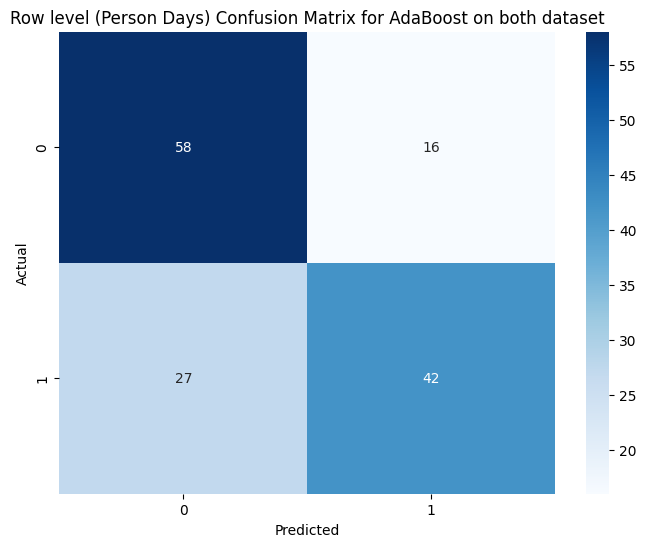

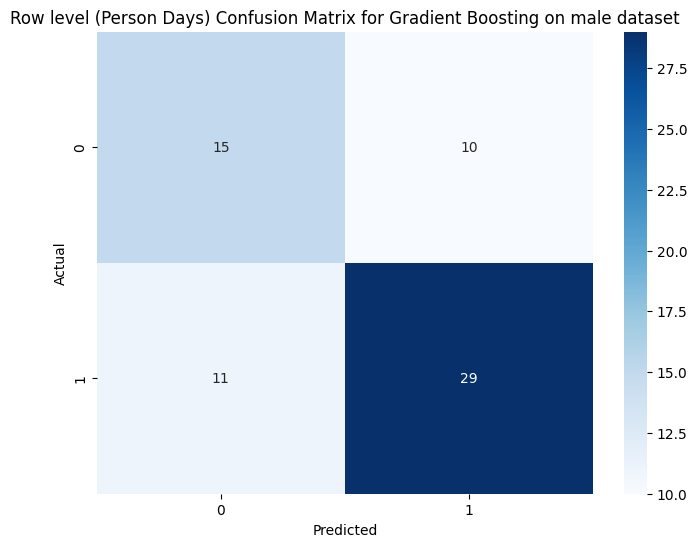

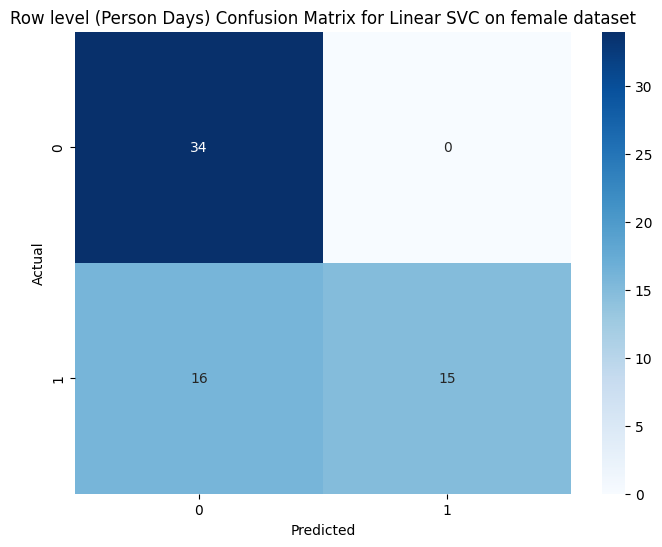

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

for dataset_name, dataset_results in all_results.items():
    # sort the models based on accuracy
    accuracy_sorted = sorted(dataset_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    # best performing model
    best_model_name, best_model_results = accuracy_sorted[0]
    
    # confusion matrix
    cm = best_model_results['cm']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f"Row level (Person Days) Confusion Matrix for {best_model_name} on {dataset_name} dataset")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In order to predict a person's depression state, the predictions need to be aggregated from row level to person level - that is, `id` in this dataset. Because there are only 55 persons in this dataset, and we have not synthesised data at this stage, we have opted for a cross-validation approach using the entire dataset to make predictions.  The predictions are then aggregated - to a single prediction per person:

`fit_and_person_conf_matrix` - fits and evaluates multiple models and prepares a confusion matrix based on chosen metric (default is accuracy) and aggregation (default is mode)

This aggregation method is what may be employed as a voting mechanism in an ensemble mmodel or if predicting whether an individual is depressed with row level data.  Alternatively, the data can be reshaped to be wide instead of long.

Best performing model on both: Logistic Regression
Confusion Matrix:
[[28  4]
 [ 9 14]]


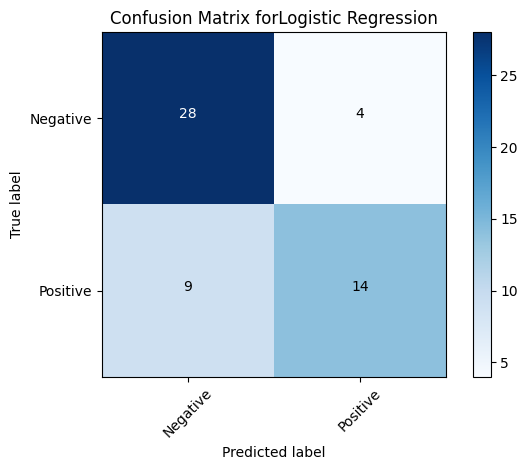

Best performing model on male: Naive Bayes
Confusion Matrix:
[[8 4]
 [5 8]]


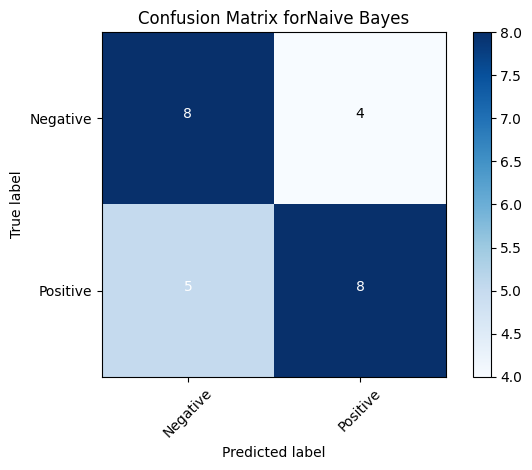

Best performing model on female: Logistic Regression
Confusion Matrix:
[[18  2]
 [ 6  4]]


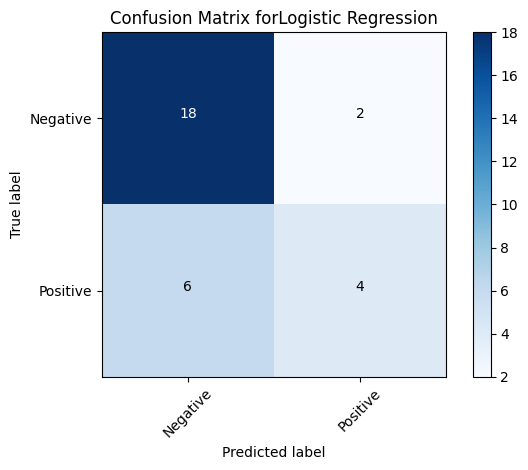

In [21]:
datasets = {
    'both': both,
    'male': male,
    'female': female
}

for name, data in datasets.items():
    # Check if 'label' column exists in the dataframe before proceeding
    if 'label' in data.columns:
        model, cm = fit_and_person_conf_matrix(data, models, metric='accuracy', aggregation_method='mode')
        print(f"Best performing model on {name}:", model)
        print("Confusion Matrix:")
        print(cm)
        plt.show()
    else:
        print(f"'label' column not found in {name} dataset. Please check your data.")
